### Multi label Classification of Classes,Computer Science,Physics,Mathematics,Statistics,Quantitative, Biology,Quantitative Finance

## Classification oneVSone label with Naive Biase and Logistic regression

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import string
nlp = spacy.load('en_core_web_sm') #Loading spacy english

# -------------------- Reading Files ---------------------

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [5]:
sample.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,0,0,0
1,20974,0,0,0,0,0,0
2,20975,0,0,0,0,0,0
3,20976,0,0,0,0,0,0
4,20977,0,0,0,0,0,0


In [6]:
print(len(train))
print(len(test))
print(len(sample))

20972
8989
8989


### -------------------- Checking Null value ----------------------

In [7]:
train.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [8]:
test.isnull().sum()

ID          0
TITLE       0
ABSTRACT    0
dtype: int64

## Concating columns of dataset

In [9]:
train['text'] = train['TITLE'] + train['ABSTRACT']
test['text'] = test['TITLE'] + test['ABSTRACT']

### Droping column after concating

In [10]:
train_data = train.drop(['TITLE', 'ABSTRACT'],axis = 1)
test_data = test.drop(['TITLE', 'ABSTRACT'],axis = 1)

## Defining function for text cleaning

In [11]:
punct = string.punctuation

def clean(text):
    text = text.lower()  #Convert text in lower case
    text = text.replace("[^a-zA-Z#]", " ")
    punc_removed = [char for char in text if char not in punct]  #Removing Punctuations
    punc_removed_join = ''.join(punc_removed) 
    
    doc= nlp(punc_removed_join)
    text_out = [token.lemma_ for token in doc if token.is_stop == False and token.is_alpha and len(token)>2]
    txt = ' '.join(text_out)
    return txt

In [12]:
train_data['text'] = train_data['text'].apply(clean)
test_data['text'] = test_data['text'].apply(clean)

In [13]:
col = list(train_data.columns)
target = col[1:7]
print(target)

['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']


### Target Values

In [14]:
y = train_data[target]
y.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,1,0,0,1,0,0


## Ploting Target

<AxesSubplot:>

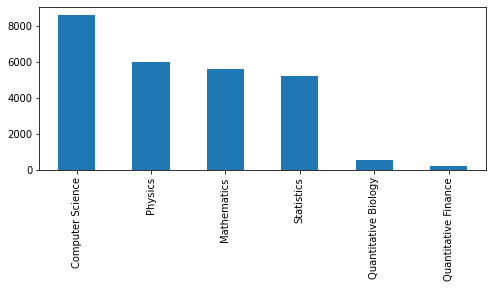

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size

y.sum(axis=0).plot.bar()

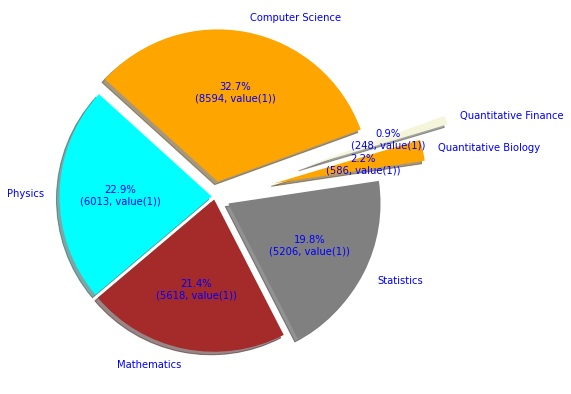

In [16]:
import numpy as np
explode = (0.1, 0.02, 0.02, 0.1, 0.4, 0.6) 
  
# Creating color parameters 
colors = ( "orange", "cyan", "brown","grey", "orange", "beige") 
  
# Wedge properties 
wp = { 'linewidth' : 1, 'edgecolor' : "green" } 
  
# Creating autocpt arguments 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d}, value(1))".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(15,7)) 
wedges, texts, autotexts = ax.pie(y.sum(axis=0),  
                                  autopct = lambda pct: func(pct, y.sum(axis=0)), 
                                  explode = explode,  
                                  labels = target, 
                                  shadow = True, 
                                  colors = colors, 
                                  startangle = 20, 
#                                   wedgeprops = wp, 
                                  textprops = dict(color ="blue")) 
  
plt.show()

# ----------------------- Naive Bayes Classifier -------------------------
### Train Test Split text

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
def NaiveBase(train, test, column_index):
    X_train, X_test, y_train, y_test = train_test_split(train_data['text'], y[target[column_index]], 
                                                        test_size=0.25,random_state=42)
    
    cv = CountVectorizer()
    
    train_cv = cv.fit_transform(X_train)
    test_cv = cv.transform(X_test)

    nb = MultinomialNB()
    nb.fit(train_cv, y_train)
    predictions = nb.predict(test_cv)

    print('Accuracy score : ', accuracy_score(y_test, predictions).round(2))
    print('F1 score       : ', f1_score(y_test, predictions,average="micro").round(2))    
    print('Precision score: ', precision_score(y_test, predictions).round(2))
#     print('classification_report: ')
#     print(classification_report(y_test, predictions))
#     print('Recall score: ', recall_score(y_test, predictions).round(2))

    df_test = cv.transform(test_data['text'])
    test_pred = nb.predict(df_test)

    return pd.Series(test_pred)

## Predicting All Labels In Naive Baise

In [18]:
NB_pred0 = NaiveBase(train_data, test_data, 0)

Accuracy score :  0.85
F1 score       :  0.85
Precision score:  0.77


In [19]:
NB_pred1 = NaiveBase(train_data, test_data, 1)

Accuracy score :  0.93
F1 score       :  0.93
Precision score:  0.9


In [20]:
NB_pred2 = NaiveBase(train_data, test_data, 2)

Accuracy score :  0.89
F1 score       :  0.89
Precision score:  0.8


In [21]:
NB_pred3 = NaiveBase(train_data, test_data, 3)

Accuracy score :  0.86
F1 score       :  0.86
Precision score:  0.67


In [22]:
NB_pred4 = NaiveBase(train_data, test_data, 4)

Accuracy score :  0.97
F1 score       :  0.97
Precision score:  0.68


In [23]:
NB_pred5 = NaiveBase(train_data, test_data, 5)

Accuracy score :  0.99
F1 score       :  0.99
Precision score:  1.0


In [24]:
NB_test_preds = pd.concat((sample['ID'], NB_pred0, NB_pred1, NB_pred2,NB_pred3,NB_pred4,NB_pred5), axis=1)
NB_test_preds.columns = ['ID'] + target

In [25]:
NB_test_preds.to_csv('NB_test_sample.csv')

# -------------------- Logistic Regression ----------------------------

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
def LogisticReg(train, test, column_index):
    X_train, X_test, y_train, y_test = train_test_split(train_data['text'], y[target[column_index]], 
                                                        test_size=0.30,random_state=42)
    
    cv = CountVectorizer()
    
    train_cv = cv.fit_transform(X_train)
    test_cv = cv.transform(X_test)

    lr = LogisticRegression()
    lr.fit(train_cv, y_train)
    predictions = lr.predict(test_cv)

    print('Accuracy score : ', accuracy_score(y_test, predictions).round(2))
    print('F1 score       : ', f1_score(y_test, predictions,average="micro").round(2))
    print('Precision score: ', precision_score(y_test, predictions).round(2))
#     print('Recall score: ', recall_score(y_test, predictions).round(2))
#     print('classification_report: ')
#     print(classification_report(y_test, predictions))    

    df_test = cv.transform(test_data['text'])
    test_pred = lr.predict(df_test)

    return pd.Series(test_pred)

## Predicting All Labels In Logistic Regression

In [27]:
LR_test_pred0 = LogisticReg(train_data,test_data,0)

Accuracy score :  0.83
F1 score       :  0.83
Precision score:  0.8


In [28]:
LR_test_pred1 = LogisticReg(train_data,test_data,1)

Accuracy score :  0.92
F1 score       :  0.92
Precision score:  0.89


In [29]:
LR_test_pred2 = LogisticReg(train_data,test_data,2)

Accuracy score :  0.89
F1 score       :  0.89
Precision score:  0.79


In [30]:
LR_test_pred3 = LogisticReg(train_data,test_data,3)

Accuracy score :  0.86
F1 score       :  0.86
Precision score:  0.73


In [31]:
LR_test_pred4 = LogisticReg(train_data,test_data,4)

Accuracy score :  0.97
F1 score       :  0.97
Precision score:  0.58


In [32]:
LR_test_pred5 = LogisticReg(train_data,test_data,5)

Accuracy score :  0.99
F1 score       :  0.99
Precision score:  0.76


In [33]:
LR_test_preds = pd.concat((sample['ID'], LR_test_pred0,LR_test_pred1,LR_test_pred2,LR_test_pred3,LR_test_pred4,LR_test_pred5), axis=1)
LR_test_preds.columns = ['ID'] + target

In [34]:
LR_test_preds.to_csv('LR_test_sample.csv')